#Load the Dataset from Kaggle

In [21]:
import os
import shutil
import zipfile

run = False

if run:

    # upload kaggle.json
    from google.colab import files
    files.upload()

    # Create the directory if not exists
    os.makedirs("/root/.kaggle", exist_ok=True)

    # Move kaggle.json to ~/.kaggle
    shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

    # Set permissions
    os.chmod("/root/.kaggle/kaggle.json", 600)

    # Download competition data
    !kaggle competitions download -c ucsc-cse-144-winter-2025-final-project

    # unzip the competition data
    with zipfile.ZipFile("ucsc-cse-144-winter-2025-final-project.zip", "r") as zip_ref:
        zip_ref.extractall("final_project_data")

    # remove the zip file
    %rm -rf /content/ucsc-cse-144-winter-2025-final-project.zip

# Data Preparation

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import InterpolationMode
import random


In [23]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [24]:
print(torch.rand(5))

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904])


## Spliting and Augmentating Data


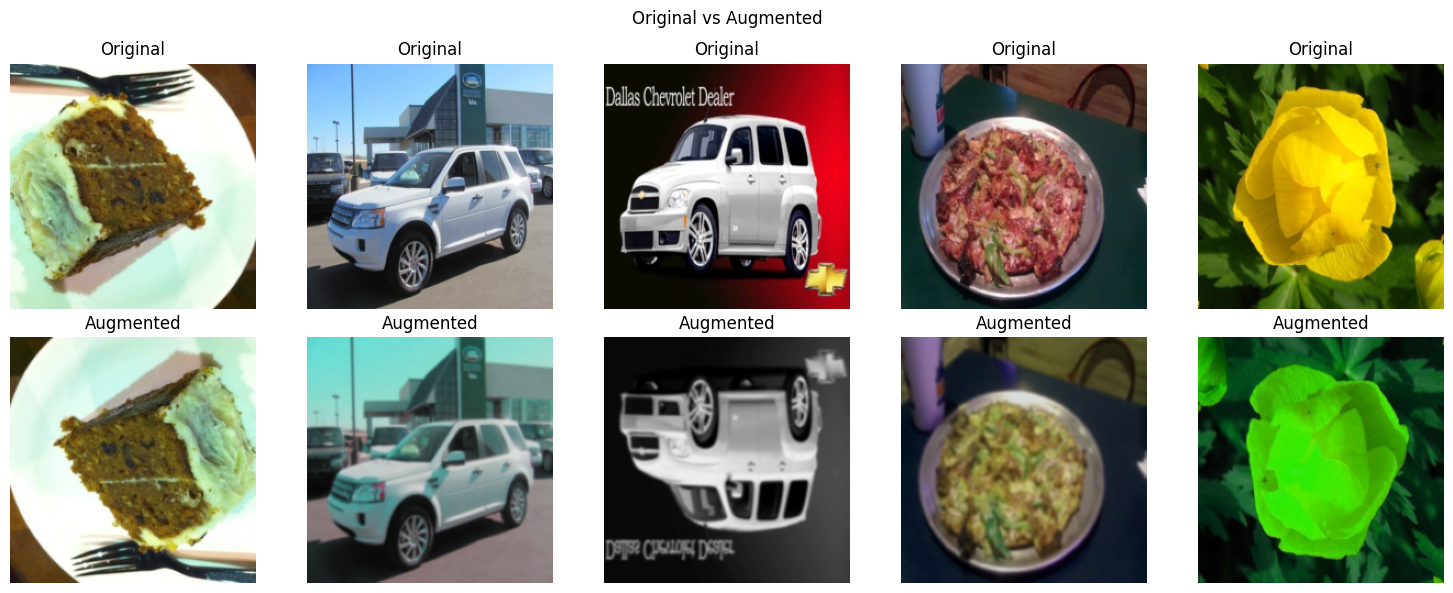

In [25]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=.15, hue=.15),
    transforms.RandomGrayscale(p=0.1),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5,interpolation=InterpolationMode.BILINEAR, fill=0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
dataset = datasets.ImageFolder("/content/final_project_data/train/train", transform=train_transform)

class_names = dataset.classes  # List of folder names representing class labels


# Define the split ratio (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])


val_data.dataset.transform = val_transform #no augmentation occur

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Reverse normalization
    return img.clamp(0, 1)

# Visualize a batch from the training DataLoader.
data_iter = iter(train_loader)
images, labels = next(data_iter)

num_samples = len(dataset.samples)
random_indices = np.random.choice(num_samples, 5, replace=False)

plt.figure(figsize=(15, 6))
for j, idx in enumerate(random_indices):
    # Get image path from dataset samples
    img_path, _ = dataset.samples[idx]

    # Load the image using PIL
    original_pil = Image.open(img_path).convert("RGB")

    # Apply transforms:
    original_tensor = val_transform(original_pil)
    augmented_tensor = train_transform(original_pil)

    # Unnormalize and convert to NumPy arrays for display
    original_img = unnormalize(original_tensor).permute(1, 2, 0).numpy()
    augmented_img = unnormalize(augmented_tensor).permute(1, 2, 0).numpy()

    # Plot original on the top row
    plt.subplot(2, 5, j + 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    # Plot augmented on the bottom row
    plt.subplot(2, 5, j + 6)
    plt.imshow(augmented_img)
    plt.title("Augmented")
    plt.axis("off")

plt.suptitle("Original vs Augmented")
plt.tight_layout()
plt.show()

In [26]:
# Print validation images
# X_train, y_train = next(iter(train_loader))

# plt.figure(figsize=(15, 5))
# for i in range(10):
#     plt.subplot(1, 10, i + 1)
#     original_img = unnormalize(X_train[i]).permute(1, 2, 0).numpy()

#     plt.imshow(original_img)  # Show the image
#     plt.axis("off")
#     plt.title(f"Class: {class_names[y_train[i]]}")  # Display the label

# plt.tight_layout()
# plt.show()

# Model

In [27]:
# Function for training the model
def train(model, train_loader, criterion, optimizer, device, accumulation_steps=1):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    optimizer.zero_grad()  # Zero the gradients before starting batch accumulation

    do = False

    for batch_idx, (inputs, labels) in enumerate(train_loader):

        if do:
            plt.imshow(np.transpose(inputs[0], (1, 2, 0)))  # Show the image
            plt.axis("off")
            plt.title(f"Class: {labels[0]}")  # Display the label

            plt.tight_layout()
            plt.show()

        inputs, labels = inputs.to(device), labels.to(device)



        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels) / accumulation_steps  # Normalize loss
        running_loss += loss.item() * accumulation_steps  # Re-scale loss for tracking

        # Backward pass
        loss.backward()

        # Perform optimizer step after accumulation_steps batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()  # Reset gradients after step

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    return epoch_loss, epoch_accuracy

# Function for validating the model
def validate(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = (correct / total) * 100

    return epoch_loss, epoch_accuracy




In [28]:
weight_decay = 0.01
fine_tune_lr = 0.0001
normal_lr = 0.01
num_epochs = 17
momentum = 0.9

In [29]:
model_conv = torch.hub.load("facebookresearch/swag", model="vit_l16")
# model_conv = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

new_classifier = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.4),  # Adjust dropout probability as needed (e.g., 0.1, 0.3)
    nn.Linear(in_features=512, out_features=100),
)


model_conv.head = new_classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.head.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(model_conv.head.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


Using cache found in /root/.cache/torch/hub/facebookresearch_swag_main


In [30]:
print(type(model_conv))

<class 'models.vision_transformer.ViTL16'>


In [31]:
model_conv

ViTL16(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0, inplace=False)
    (layers): Sequential(
      (layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (dropout_1): Dropout(p=0, inplace=False)
          (linear_2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout_2): Dropout(p=0, inplace=False)
        )
      )
      (layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (s

In [32]:
# Check if a GPU is available and move the model to the appropriate device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# Initialize lists to store metrics
losses_train = []
losses_val = []
accs_val = []
accs_train = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model and record training loss
    train_loss, train_accuracy = train(model_conv, train_loader, criterion, optimizer, device)
    losses_train.append(train_loss)
    accs_train.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validate the model and record validation loss and accuracy
    val_loss, val_accuracy = validate(model_conv, val_loader, criterion, device)
    losses_val.append(val_loss)
    accs_val.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Update learning rate scheduler
    scheduler.step()

Epoch 1/17
Train Loss: 3.4021, Train Accuracy: 27.12%
Validation Loss: 1.9623, Validation Accuracy: 54.50%
Epoch 2/17
Train Loss: 1.2774, Train Accuracy: 63.62%
Validation Loss: 1.2315, Validation Accuracy: 67.00%
Epoch 3/17
Train Loss: 0.7818, Train Accuracy: 75.62%
Validation Loss: 0.9792, Validation Accuracy: 71.00%
Epoch 4/17
Train Loss: 0.5570, Train Accuracy: 81.75%
Validation Loss: 0.8815, Validation Accuracy: 73.00%
Epoch 5/17
Train Loss: 0.4582, Train Accuracy: 85.88%
Validation Loss: 0.7720, Validation Accuracy: 75.50%
Epoch 6/17
Train Loss: 0.4030, Train Accuracy: 87.38%
Validation Loss: 0.7375, Validation Accuracy: 77.00%
Epoch 7/17
Train Loss: 0.3454, Train Accuracy: 87.50%
Validation Loss: 0.7263, Validation Accuracy: 78.00%
Epoch 8/17
Train Loss: 0.2772, Train Accuracy: 90.88%
Validation Loss: 0.7973, Validation Accuracy: 75.00%
Epoch 9/17
Train Loss: 0.2515, Train Accuracy: 91.62%
Validation Loss: 0.8191, Validation Accuracy: 73.50%
Epoch 10/17
Train Loss: 0.2171, Train

In [33]:
torch.save(model_conv.state_dict(), 'model_weights.pth')

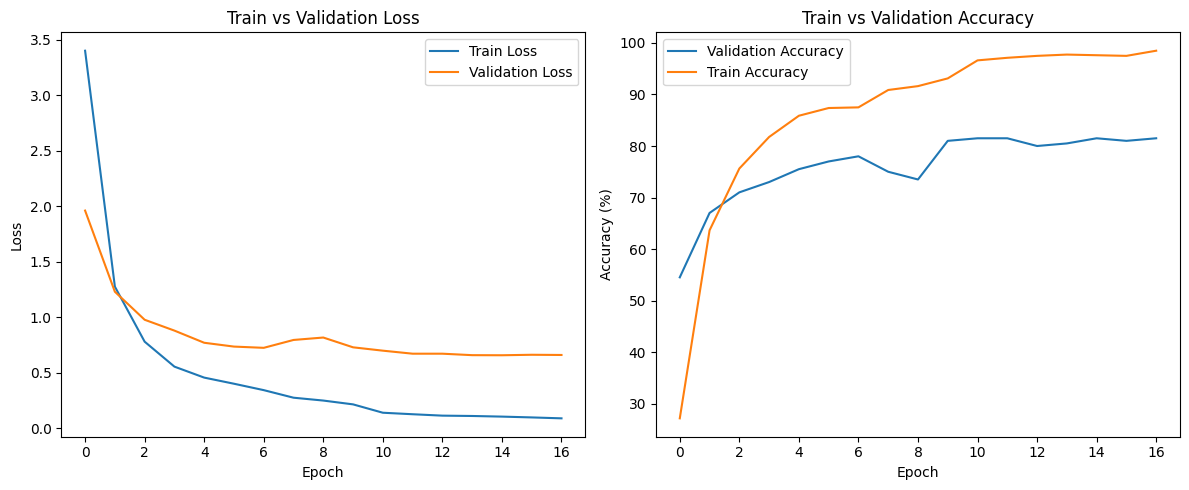

In [34]:
# Plotting validation vs test metrics
epochs_arr = np.arange(num_epochs)

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Loss
axes[0].plot(epochs_arr, losses_train, label="Train Loss")
axes[0].plot(epochs_arr, losses_val, label="Validation Loss")
axes[0].set_title("Train vs Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Accuracy
axes[1].plot(epochs_arr, accs_val, label="Validation Accuracy")
axes[1].plot(epochs_arr, accs_train, label="Train Accuracy")
axes[1].set_title("Train vs Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend()

plt.tight_layout()
plt.show()

In [35]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from torchvision import transforms

# Define the transformation for test images (same as validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create a custom dataset for the test images that returns the filename along with the image
class TestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # List all image files in the directory (you can adjust the extensions as needed)
        self.image_paths = [os.path.join(root, fname) for fname in sorted(os.listdir(root))
                            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # Return image tensor and the filename (ID)
        return image, os.path.basename(img_path)

# Create the test dataset and dataloader
test_dir = "/content/final_project_data/test/test"  # Update with your test directory path
test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Ensure your model is in evaluation mode and on the correct device
model_conv.eval()  # Assuming model_conv is your final trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv = model_conv.to(device)

# Prepare lists to store the filenames and predictions
image_names = []
predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for inputs, filenames in test_loader:
        inputs = inputs.to(device)
        outputs = model_conv(inputs)
        # For classification, the predicted class is the index with maximum logit
        _, predicted = torch.max(outputs, 1)

        # Collect the predictions and corresponding filenames
        predictions.extend(predicted.cpu().numpy())
        image_names.extend(filenames)

# Create a DataFrame with the submission format
submission_df = pd.DataFrame({
    'ID': image_names,      # Use the image filenames as IDs
    'Label': predictions    # Predicted labels as integers (0-99)
})
submission_df['Label'] = submission_df['Label'].map(lambda x: class_names[x])
# Save the DataFrame to a CSV file named submission.csv
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'
